In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns


In [2]:
df = pd.read_csv('data/gd.csv', delimiter=';')

In [3]:
#df.insert(0, 'ones', 1.)

In [4]:
np.ones(df.shape[1])

array([1., 1., 1.])

In [5]:
df.y = df.y * np.random.rand(df.shape[0])
df

,x,y,iter
0,5.000000,1.514851,0
1,4.000000,3.227048,1
2,3.375300,0.372260,2
3,2.908990,0.504307,3
4,2.536090,0.991161,4
...,...,...,...
87,0.000235,0.000055,87
88,0.000210,0.000113,88
89,0.000188,0.000159,89
90,0.000169,0.000005,90


In [6]:
df = df.drop(columns = 'iter')

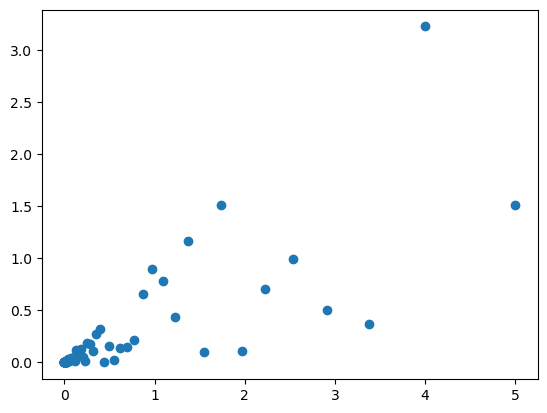

In [7]:
plt.scatter(df.x, df.y)

In [8]:
x = df.drop(columns = 'y')
y = df.y
weights = np.ones(x.shape[1])
weights

array([1.])

In [9]:

2/x.shape[0] * np.dot((np.dot(x, weights)-y), x)


array([1.19869456])

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns



In [11]:
df = pd.read_csv('data/Raisin_Dataset.csv')
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [12]:
df.Class.value_counts()

Class
Kecimen    450
Besni      450
Name: count, dtype: int64

In [13]:
df.Class = df.Class.map({'Kecimen':0, 'Besni': 1})

<Axes: >

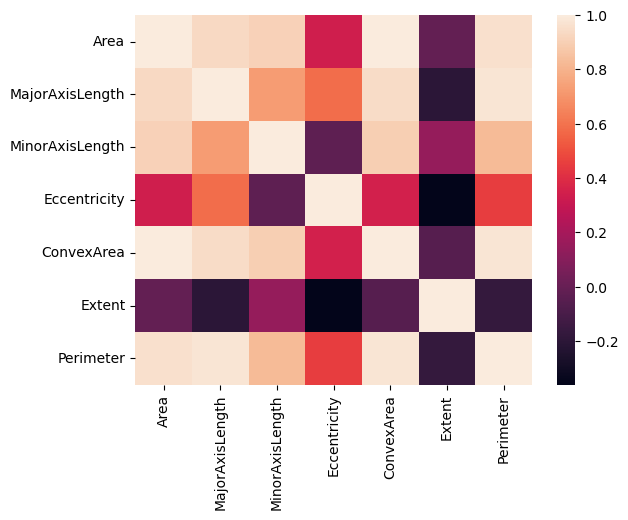

In [14]:
sns.heatmap(df.drop(columns = 'Class').corr())

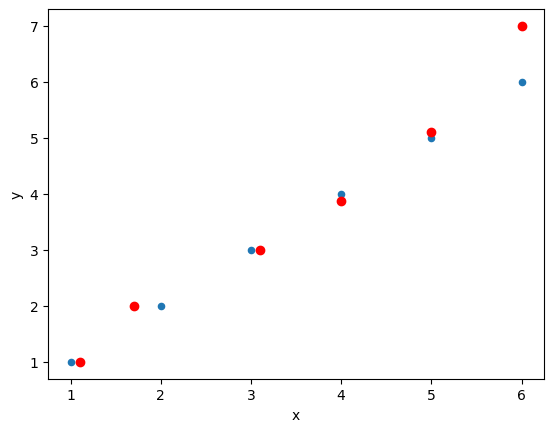

In [15]:
x_train = pd.DataFrame({'x':[1,2,3,4,5, 6], 'y':[1,2,3,4,5, 6]})
target = pd.Series([1,1,1,0,0,0])
x_train.assign(t = target.values)

x_test = pd.DataFrame({'x':[1.1, 1.7, 3.1, 4,5,6], "y" : [1,2,3, 3.88, 5.1, 7]})
x_train.plot(kind = 'scatter', x = 'x', y = 'y')
plt.scatter(x_test.x, x_test.y, c = 'red')

In [193]:
class MyKMeans():
    def __init__(self, n_clusters = 3, max_iter = 10, n_init = 3, random_state = 42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.n_init = n_init
        self.random_state = random_state
        self.cluster_centers_  = np.zeros(n_clusters, dtype=object)
        self.inertia_ = 0
    
    def fit(self, X):
        np.random.seed(seed=self.random_state)
        
        x = X.values
        
        idx = np.random.choice(x.shape[0], self.n_clusters, replace=False)
        #Randomly choosing Centroids 
        self.cluster_centers_ = x[idx, :] 
        
        
        
        for idx in range(self.max_iter):                    
            dist_arr = np.zeros((x.shape[0], self.n_clusters))
            for i in range(self.cluster_centers_.shape[0]): #находим дистанции до центроид, где ось 0 - центроиды, а ось 1 - расстояния до точек
                dist_arr[:, i] = np.sqrt(((x - self.cluster_centers_ [i])**2).sum(axis = 1))
        
            cluster_classes = dist_arr.argmin(axis = 1) # вычисление ближайших центроид
            for i in range(self.n_clusters):            # подсчет инерции для итогового кластера
                filter = (cluster_classes == i)
                self.inertia_= np.power(dist_arr[filter, i], 2).sum()
                
            for i in range(self.n_clusters):            # нахождение средних координат для кластеров
                filter = (cluster_classes == i)
                if filter.sum() > 1:
                    self.cluster_centers_[i] = x[filter].mean(axis = 0)


In [194]:
import numpy as np
from scipy.spatial.distance import cdist 
 
#Function to implement steps given in previous section
def Kmeans(x,k, no_of_iterations, random_state = 42):
    np.random.seed(seed=random_state)
    idx = np.random.choice(len(x), k, replace=False)
    #Randomly choosing Centroids 
    centroids = x[idx, :] #Step 1
     
    #finding the distance between centroids and all the data points
    distances = cdist(x, centroids ,'euclidean') #Step 2
    print(distances)
    #Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances]) #Step 3
     
    #Repeating the above steps for a defined number of iterations
    #Step 4
    for _ in range(no_of_iterations): 
        centroids = []
        for idx in range(k):
            #Updating Centroids by taking mean of Cluster it belongs to
            temp_cent = x[points==idx].mean(axis=0) 
            centroids.append(temp_cent)
 
        centroids = np.vstack(centroids) #Updated Centroids 
         
        distances = cdist(x, centroids ,'euclidean')
        points = np.array([np.argmin(i) for i in distances])
         
    return points 

In [195]:
kmeans = MyKMeans(**{"n_clusters": 10, "max_iter": 10, "n_init": 3})

In [196]:
df = pd.DataFrame({'a':np.random.randint(1, 10, 10), 'b':np.random.randint(1, 10, 10)})
df

,a,b
0,9,7
1,7,8
2,2,3
3,4,1
4,9,4
5,2,2
6,9,8
7,5,4
8,2,2
9,4,6


In [197]:
six = np.random.normal(loc = [6], scale = .5, size = (2, 20))
nine = np.random.normal(loc = [9], scale = .5, size = (2, 20))
df = pd.DataFrame(np.hstack((six, nine)), index = ['x', 'y']).T
df

,x,y
0,6.161500,6.318153
1,5.303292,5.546640
2,4.910833,6.238021
3,5.478052,6.651831
4,6.086347,6.105794
5,6.162099,6.298522
6,6.372930,5.551832
7,5.081708,5.944006
8,6.282232,6.734471
9,6.012750,5.438051


<Axes: xlabel='x', ylabel='y'>

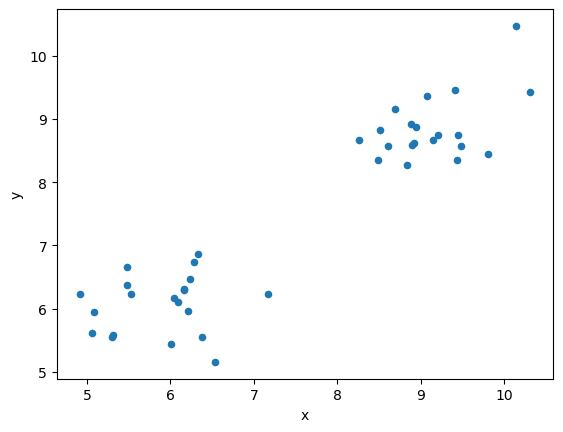

In [198]:
df.plot(kind = 'scatter', x = 'x', y = 'y')

In [199]:
kmeans.fit(df)

In [200]:
kmeans.cluster_centers_

array([[5.19094261, 5.66971166],
       [5.34710887, 6.37295262],
       [6.13354109, 6.1690663 ],
       [8.46810992, 8.5994818 ],
       [6.28280801, 6.69091052],
       [7.17037317, 6.22894254],
       [8.89973729, 9.07789608],
       [9.95741455, 9.78474482],
       [9.24419486, 8.55590144],
       [6.30705757, 5.38257985]])

In [201]:
kmeans.inertia_

0.22536258348136476

In [157]:
class TwoPointers():
    def __init__(self, col, sep):
        self.col = col
        self.sep = sep
        self.right = None
        self.left = None
        self.left_prob = None
        self.right_prob = None
        self.is_right = None # 1 или 0
        self.ig = None


def entropy_shennon(y: np.array):
    ans = 0
    for i in np.unique(y):
        si = (y == i).sum() / y.shape[0]
        ans -= si * np.log2(si)
    return ans

def IG (*y_arr):
    ans = entropy_shennon(y_arr[0])
    N = y_arr[0].shape[0]
    for yi in y_arr[1:]:
        Ni = yi.shape[0]
        ans -= Ni/N * entropy_shennon(yi) 
    return ans

def get_best_split(X:np.array, y:np.array):
    ig = 0
    split_value = 0
    col_name = ''
    for col in range(X.shape[1]):
        unique_sorted = np.sort(np.unique(X[:, col]))
        separators = np.zeros(unique_sorted.shape[0] - 1)
        for i in range(unique_sorted.shape[0] - 1):
            separators[i] = (unique_sorted[i] + unique_sorted[i+1]) / 2
        
        for sep in separators:
            right = y[X[:, col] > sep]
            left = y[X[:, col] <= sep]
            ig_local = IG(y, right, left)
            
            if ig_local > ig:
                ig = ig_local
                col_name = col
                split_value = sep 
    return (col_name, split_value, ig)

def tree_builder(x, y, curr_depth:int, Node, min_samples_split, max_depth:int = -1, is_right = 0):
        if (x.shape[0] < min_samples_split) or (np.unique(y).shape[0] <=1) or (curr_depth == max_depth):
            if is_right == 1:
                Node.right_prob = (y == 1).sum() / y.shape[0]
                Node.left_prob = 0.0
            else:
                Node.left_prob = (y == 1).sum() / y.shape[0]
                Node.right_prob = 0.0
            return Node

        else:
            best_split = get_best_split(x, y)
            
            right_x = x[x[:, best_split[0]] > best_split[1]]
            left_x  = x[x[:,  best_split[0]] <= best_split[1]]
            
            right_y = y[x[:, best_split[0]] > best_split[1]]
            left_y = y[x[:,  best_split[0]] <= best_split[1]]
            
            Node.col = best_split[0]
            Node.sep = best_split[1]
            Node.left =  tree_builder(left_x,  left_y,  curr_depth + 1, TwoPointers(None, None), min_samples_split, max_depth, 0)
            Node.right = tree_builder(right_x, right_y, curr_depth + 1, TwoPointers(None, None), min_samples_split, max_depth, 1)
            Node.ig = best_split[2]
        
        return Node


    
def tree_reader(node, indent = ''):
    if (node.left == None) and (node.right == None):
        #if node.is_right == 1:
        #    print(indent, 'right_prob =', node.right_prob)
        #else:print(indent, 'right_prob =', node.right_prob)
        print(indent, node.ig)

    else:
        print(indent, 'col:', node.col, 'sep:', node.sep)
        tree_reader(node.right, indent + '  ')
        tree_reader(node.left, indent + '  ')
        
class MyTreeClf():

    def __init__(self, max_depth = 5, min_samples_split = 10, max_leafs = None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_leafs = max_leafs
        self.leafs_cnt = 0
        self.tree = None
    
    def leaf_counter(self, node):
        if (node.left == None) and (node.right == None):
            self.leafs_cnt +=1

        else:
            self.leaf_counter(node.right)
            self.leaf_counter(node.left )

    def tree_pruner(self, node):
        if (node.left.left == None) and (node.left.right == None): # <-- если левая ветка имеет листья
            pass
 
    def fit (self, X, y):
        self.tree = TwoPointers(None, None)
        X = X.values
        y = y.values
        tree_builder(X, y, 0, self.tree, self.min_samples_split, max_depth=self.max_depth)
        self.leaf_counter(self.tree)
        
        if self.leafs_cnt > self.max_leafs:
            self.tree_pruner(self.tree)
    
    def display_tree(self):
        tree_reader(self.tree)
    
    def print_leafs_count(self):
        return self.leafs_cnt

In [158]:
Kmeans(df.values, 4, 10)

[[1.12320517 0.64355306 0.36191606 3.32231515]
 [0.03411857 0.72167085 0.99584681 4.47628519]
 [0.77473474 0.61266711 1.32826057 4.36925434]
 [1.08584748 0.42039563 1.00722154 3.66910351]
 [0.93327796 0.57725456 0.19130727 3.52286885]
 [1.11082485 0.64187483 0.34238593 3.33518148]
 [1.05664619 1.08938843 0.43913208 3.75208785]
 [0.43485721 0.52839807 1.12794828 4.39436313]
 [1.50656319 0.90899346 0.77843062 2.96040825]
 [0.71007966 0.93421154 0.55729501 4.06414145]
 [1.28487285 0.75276715 0.51627107 3.16158753]
 [1.6364281  1.02269601 0.91175494 2.84446531]
 [1.96471387 1.64689452 0.99790304 2.74336116]
 [1.28927951 1.47716672 0.86531794 3.98834839]
 [0.93696132 0.52943367 0.26007729 3.51060872]
 [0.97098042 0.73892603 0.         3.54194666]
 [0.6877002  0.         0.73892603 3.86698552]
 [0.80594102 0.14229798 0.83962674 3.82635649]
 [0.25646378 0.7758107  1.19937778 4.61629028]
 [0.         0.6877002  0.97098042 4.44529302]
 [4.7148001  4.1507238  3.79650858 0.31940424]
 [4.55575086 

array([2, 0, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)